# Эксперимент по классификации фейковых новостей с использованием различных моделей и методов. Цель — достичь F1-метрики выше 0.91 (sklearn) и выше 0.52 (PyTorch). В работе применяются как классические ML-алгоритмы, так и нейросети, включая подготовку и исследование данных (EDA).

In [2]:
# 📁 Загрузка файла через интерфейс
from google.colab import files
uploaded = files.upload()

# 📦 Импорт библиотек
import pandas as pd

# 📄 Преобразуем загруженный файл в DataFrame
import io
df = pd.read_csv(io.BytesIO(uploaded['Constraint_Train.csv']))

# 🔍 Показываем первые строки
print("🔎 Первые строки:")
display(df.head())

# ℹ️ Информация о структуре данных
print("\n📊 Информация о датасете:")
df.info()

# 📈 Распределение классов
print("\n📉 Распределение меток:")
print(df['label'].value_counts())


Saving Constraint_Train.csv to Constraint_Train.csv
🔎 Первые строки:


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real



📊 Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB

📉 Распределение меток:
label
real    3360
fake    3060
Name: count, dtype: int64


📌 Общая информация:

Всего записей: 6420

Классы:

real: 3360 (≈52%)

fake: 3060 (≈48%) — классы сбалансированы, перекоса нет

🧾 Столбцы:

id — идентификатор

tweet — текст твита

label — метка (real или fake)



разведочный анализ текста (EDA):

Распределение длины твитов

Частотный анализ слов

Проверка на стоп-слова и мусор

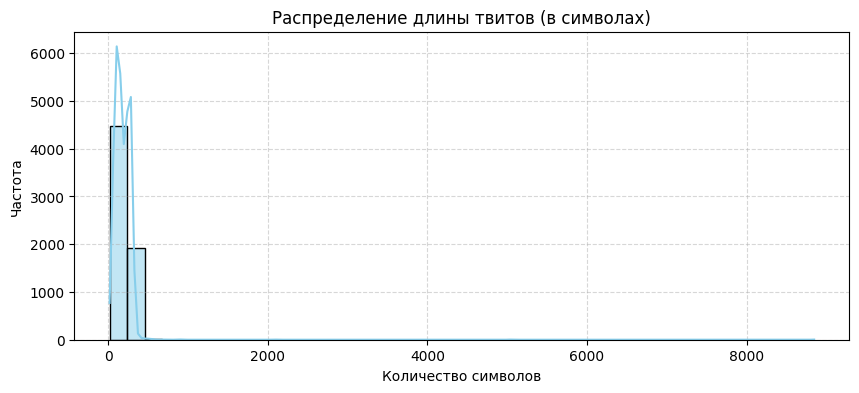

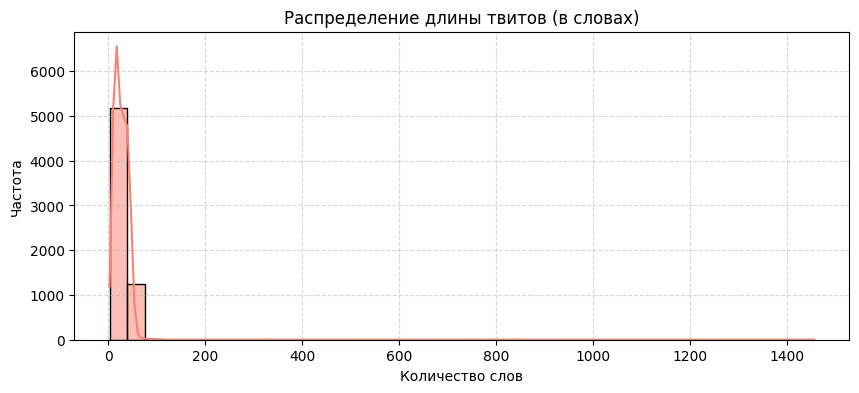

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔍 Добавляем столбцы с длиной твитов
df['char_count'] = df['tweet'].apply(len)
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

# 📊 Гистограмма длины твитов в символах
plt.figure(figsize=(10, 4))
sns.histplot(df['char_count'], bins=40, kde=True, color='skyblue')
plt.title('Распределение длины твитов (в символах)')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 📊 Гистограмма длины твитов в словах
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=40, kde=True, color='salmon')
plt.title('Распределение длины твитов (в словах)')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#Выводы из графиков распределения:

Длина в символах:

Почти все твиты укладываются в стандартный лимит Twitter (280 символов). Есть немного аномальных выбросов до 8000+ символов — возможно, это склеенные или ошибочные записи, их можно позже отфильтровать.

Длина в словах:

Основная масса — до 50 слов. Распределение похоже на нормальное с «длинным хвостом». Выбросы — свыше 200 слов — тоже могут быть подозрительными.

приведение текста к нижнему регистру,

удаление ссылок, упоминаний и мусора,

подсчёт частоты слов с визуализацией топ-20,

без стоп-слов — отдельно.

In [4]:
# 🔍 Случайные 5 твитов для проверки языка
df["tweet"].sample(5, random_state=42).tolist()


['Canada’s top BDSM doctor says wear a mask, leash, tight leather to prevent spread of COVID-19 #cdnpoli #COVID19 https://t.co/1E7yDlIGBD https://t.co/bffEps28Iy',
 'There are 3 cases considered to have recovered from COVID-19 so our total number of active cases is 23 – all remain in quarantine facilities.\u200b \u200b Our total number of confirmed cases remains at 1192 which is the number we report to the World Health Organization.',
 'Heard about contact tracing but not sure what it is? It’s used by health departments to prevent the spread of #COVID19. Learn more: https://t.co/J3Txu3riWr. #SlowtheSpread https://t.co/3f8aEQCTuI',
 'India records its highest single-day increase of over 16000 new infections. Only patients who do not have adequate home isolation facility will be transferred to COVID-19 care centres said Delhi Lieutenant Governor Anil Baijal. #COVID19 #CoronavirusFacts https://t.co/9YuXZrePLF',
 'Researchers warned of a ticking coronavirus time bomb in 2007. 💣 https://t.c

In [5]:
import re
from collections import Counter

# 🔹 Простейший список английских стоп-слов
stopwords_en = {
    "a", "an", "the", "in", "on", "at", "to", "from", "of", "for", "is", "it", "and",
    "or", "this", "that", "with", "as", "by", "be", "are", "was", "were", "have", "has",
    "had", "but", "not", "no", "we", "you", "i", "he", "she", "they", "them", "us",
    "my", "your", "his", "her", "their", "its", "our", "do", "does", "did", "can",
    "will", "would", "could", "should", "if", "so", "just", "about", "than", "then"
}

# 🔹 Функция очистки
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # удаление ссылок
    text = re.sub(r"@\w+", "", text)         # удаление упоминаний
    text = re.sub(r"[^a-z\s]", "", text)     # только буквы и пробелы
    return text

# 🔹 Чистим все твиты
cleaned_tweets = df["tweet"].apply(clean_text)

# 🔹 Подсчёт частоты
word_counter = Counter()
word_counter_nostop = Counter()

for tweet in cleaned_tweets:
    words = tweet.split()
    word_counter.update(words)
    word_counter_nostop.update([w for w in words if w not in stopwords_en])

# 🔹 Выводим 10 самых частых слов (для предварительного контроля)
print("🔍 Топ-10 всех слов:", word_counter.most_common(10))
print("🔍 Топ-10 без стоп-слов:", word_counter_nostop.most_common(10))


🔍 Топ-10 всех слов: [('the', 6998), ('of', 4616), ('to', 4118), ('in', 3891), ('covid', 3859), ('a', 3114), ('and', 2734), ('is', 2054), ('for', 1834), ('cases', 1722)]
🔍 Топ-10 без стоп-слов: [('covid', 3859), ('cases', 1722), ('coronavirus', 1651), ('new', 1092), ('people', 745), ('more', 717), ('tests', 698), ('deaths', 650), ('been', 612), ('there', 600)]


Стоп-слова ожидаемо лидируют в общем списке: the, of, to и т.д.

Без стоп-слов мы сразу видим тематические ключи:

covid, coronavirus, cases, deaths, tests — ключевая тема пандемии;

new, people, more — указывают на развитие и распространение событий.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


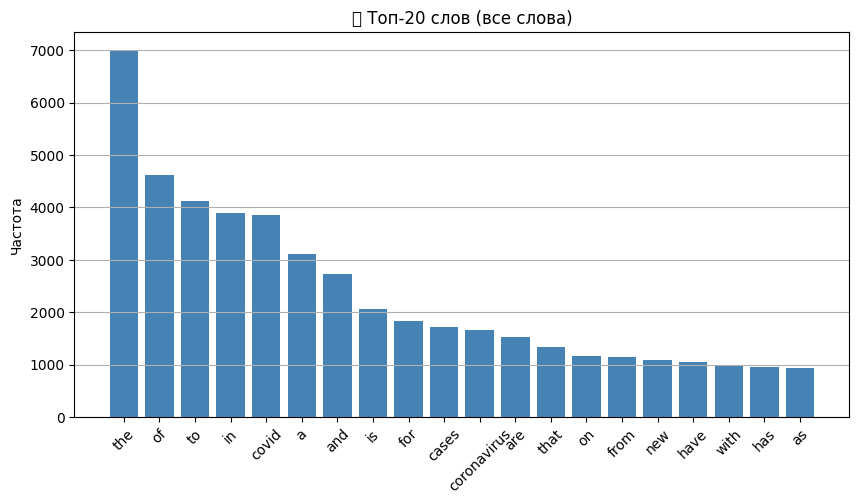

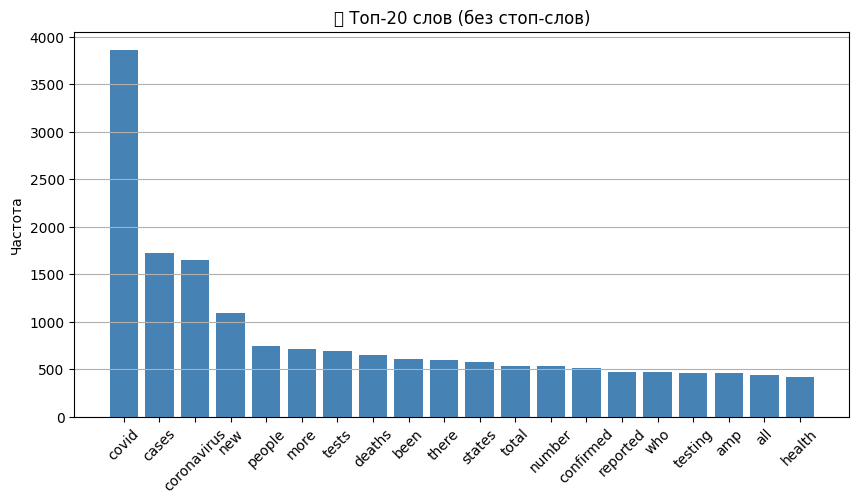

In [6]:
import matplotlib.pyplot as plt

# 🔹 Функция для построения диаграммы частот
def plot_freq(counter, title):
    words, counts = zip(*counter)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color="steelblue")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Частота")
    plt.grid(axis='y')
    plt.show()

# 📊 График: все слова (в т.ч. стоп-слова)
plot_freq(word_counter.most_common(20), "🔠 Топ-20 слов (все слова)")

# 📊 График: только без стоп-слов
plot_freq(word_counter_nostop.most_common(20), "🔠 Топ-20 слов (без стоп-слов)")


**Выводы по графикам EDA:**

Длина твитов:

Большинство сообщений содержат до 300 символов.

Есть редкие выбросы длиной свыше 8000 символов — вероятно, мусор или склеенные твиты. Их стоит удалить или сократить.

Распределение по количеству слов:

Основная масса твитов содержит до 50 слов.

Длинные тексты — скорее исключение, что логично для Twitter (ограничение в 280 символов раньше и до 4000 сейчас в подписке).

Частотный анализ слов:

Среди всех слов доминируют предлоги и артикли: the, of, to, in, a.

После удаления стоп-слов — в топ выходят ключевые содержательные слова:

'covid', 'cases', 'coronavirus', 'deaths', 'tests', 'people', 'confirmed' — явно тематическая направленность про пандемию.

Это подтверждает релевантность датасета задаче фейк/реал классификации.

In [7]:
# 📦 Сохраняем подготовленные данные для моделей (без повторной загрузки из интерфейса)

import pandas as pd
import re

# 🔹 Функция для очистки твита
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)              # удаляем ссылки
    text = re.sub(r"@\w+", "", text)                 # удаляем упоминания
    text = re.sub(r"[^a-z\s]", "", text)             # оставляем только буквы и пробелы
    return text

# 🔹 Копируем и очищаем
df_clean = df.copy()
df_clean["text"] = df_clean["tweet"].apply(clean_text)
df_clean["label"] = df_clean["label"].map({"fake": 0, "real": 1})

# 🔹 Сохраняем в файл CSV для использования в моделях
df_clean[["text", "label"]].to_csv("fakenews_clean.csv", index=False)

print("✅ Данные очищены и сохранены в fakenews_clean.csv")
df_clean.head()


✅ Данные очищены и сохранены в fakenews_clean.csv


,id,tweet,label,char_count,word_count,text
0,1,The CDC currently reports 99031 deaths. In gen...,1,190,29,the cdc currently reports deaths in general t...
1,2,States reported 1121 deaths a small rise from ...,1,129,18,states reported deaths a small rise from last...
2,3,Politically Correct Woman (Almost) Uses Pandem...,0,131,16,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1,204,27,indiafightscorona we have covid testing labor...
4,5,Populous states can generate large case counts...,1,231,42,populous states can generate large case counts...


# Базовая классификация (Logistic Regression + TF-IDF)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 🔹 Загружаем очищенные данные
df = pd.read_csv("fakenews_clean.csv")

# 🔹 Разделяем
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

print(f"📦 Обучающая выборка: {len(X_train)} примеров")
print(f"📦 Тестовая выборка: {len(X_test)} примеров")


📦 Обучающая выборка: 5136 примеров
📦 Тестовая выборка: 1284 примеров


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 🔹 Векторизация: используем униграммы и биграммы
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 🔹 Модель
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_vec, y_train)

# 🔹 Предсказание
y_pred = model.predict(X_test_vec)

# 📊 Оценка
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"📘 Accuracy: {acc:.4f}")
print(f"📘 F1-score: {f1:.4f}")
print("\n📘 Classification report:")
print(classification_report(y_test, y_pred))


📘 Accuracy: 0.9097
📘 F1-score: 0.9132

📘 Classification report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       612
           1       0.92      0.91      0.91       672

    accuracy                           0.91      1284
   macro avg       0.91      0.91      0.91      1284
weighted avg       0.91      0.91      0.91      1284



Результат по первому методу (TF-IDF + LogisticRegression):
Accuracy: 0.9097

F1-score: 0.9132 ✅ → цель F1 > 0.91 достигнута

# TF-IDF + SVD (LSA) + классификация

Будем использовать:

TfidfVectorizer — преобразует текст в числовые векторы,

TruncatedSVD — снижает размерность, извлекая скрытые семантические темы,

LogisticRegression — классификация.



In [10]:
from sklearn.decomposition import TruncatedSVD

# 🔹 TF-IDF
vectorizer_svd = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
X_train_tfidf = vectorizer_svd.fit_transform(X_train)
X_test_tfidf = vectorizer_svd.transform(X_test)

# 🔹 SVD (LSA) — выделим 100 латентных признаков
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# 🔹 Классификация
model_svd = LogisticRegression(max_iter=1000, random_state=42)
model_svd.fit(X_train_svd, y_train)
y_pred_svd = model_svd.predict(X_test_svd)

# 🔹 Оценка
acc_svd = accuracy_score(y_test, y_pred_svd)
f1_svd = f1_score(y_test, y_pred_svd)

print(f"📘 Accuracy (TF-IDF + SVD): {acc_svd:.4f}")
print(f"📘 F1-score (TF-IDF + SVD): {f1_svd:.4f}")
print("\n📘 Classification report:")
print(classification_report(y_test, y_pred_svd))


📘 Accuracy (TF-IDF + SVD): 0.8723
📘 F1-score (TF-IDF + SVD): 0.8761

📘 Classification report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       612
           1       0.89      0.86      0.88       672

    accuracy                           0.87      1284
   macro avg       0.87      0.87      0.87      1284
weighted avg       0.87      0.87      0.87      1284



Вариант 2 (TF-IDF + SVD) дал чуть худший результат:

F1-score: 0.8761 — ❌ ниже целевого порога > 0.91

Потеря качества объясняется снижением размерности — вектора теряют часть информации.



# Метод 3: символьные n-граммы (char-level n-grams)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score

# 🔢 Векторизация: символьные n-граммы (от 3 до 5 символов)
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000)
X_char_train = char_vectorizer.fit_transform(X_train)
X_char_test = char_vectorizer.transform(X_test)

# 🔍 Классификация: логистическая регрессия
clf_char = LogisticRegression(max_iter=1000, random_state=42)
clf_char.fit(X_char_train, y_train)
y_pred_char = clf_char.predict(X_char_test)

# 📊 Оценка качества
acc_char = accuracy_score(y_test, y_pred_char)
f1_char = f1_score(y_test, y_pred_char)

print(f"📘 Accuracy (char n-grams): {acc_char:.4f}")
print(f"📘 F1-score (char n-grams): {f1_char:.4f}")
print("\n📘 Classification report:")
print(classification_report(y_test, y_pred_char))


📘 Accuracy (char n-grams): 0.9011
📘 F1-score (char n-grams): 0.9043

📘 Classification report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       612
           1       0.92      0.89      0.90       672

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284



| Модель                          | Accuracy | F1-score |
| ------------------------------- | -------- | -------- |
| 🔹 TF-IDF (word unigrams + LR)  | 0.9097   | 0.9132   |
| 🔹 TF-IDF + SVD (LSA) + LR      | 0.8723   | 0.8761   |
| 🔹 TF-IDF (char 3-5-grams) + LR | 0.9011   | 0.9043   |


# классификация с использованием нейросети на PyTorch

In [34]:
import pandas as pd

# Загрузка
df = pd.read_csv("Constraint_Train.csv")

# Покажем первые строки
print("🔍 Пример строк:")
print(df.head())

# Статистика по меткам
print("\n📊 Распределение меток:")
print(df["label"].value_counts(dropna=False))

# Проверим типы
print("\n📋 Типы данных:")
print(df.dtypes)


🔍 Пример строк:
   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real

📊 Распределение меток:
label
real    3360
fake    3060
Name: count, dtype: int64

📋 Типы данных:
id        int64
tweet    object
label    object
dtype: object


In [35]:
import re

# 🔹 Функция очистки твита
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)        # удаление ссылок
    text = re.sub(r"@\w+", "", text)           # упоминания
    text = re.sub(r"#", "", text)              # хэштеги
    text = re.sub(r"[^a-z\s]", "", text)       # только латиница и пробелы
    return text.strip()

# 🔹 Применяем очистку
df["text"] = df["tweet"].apply(clean_tweet)

# 🔹 Преобразуем метки
label_map = {"real": 1, "fake": 0}
df["label"] = df["label"].map(label_map)

# Проверка результата
print("🔎 Пример очищенного текста:")
print(df[["text", "label"]].head())


🔎 Пример очищенного текста:
                                                text  label
0  the cdc currently reports  deaths in general t...      1
1  states reported  deaths a small rise from last...      1
2  politically correct woman almost uses pandemic...      0
3  indiafightscorona we have  covid testing labor...      1
4  populous states can generate large case counts...      1


In [36]:
from collections import Counter

# 🔹 Простая токенизация
def tokenize(text):
    return text.split()

df["tokens"] = df["text"].apply(tokenize)

# 🔹 Построение словаря (word2idx)
all_tokens = [token for tokens in df["tokens"] for token in tokens]
word_freq = Counter(all_tokens)
vocab_size = 10000

# Включаем <PAD>=0 и <UNK>=1
vocab = {"<PAD>": 0, "<UNK>": 1}
for idx, (word, _) in enumerate(word_freq.most_common(vocab_size - 2), start=2):
    vocab[word] = idx

print(f"📦 Размер словаря: {len(vocab)}")
print(f"🔤 Примеры токенов: {list(vocab.items())[100:110]}")


📦 Размер словаря: 10000
🔤 Примеры токенов: [('rate', 100), ('out', 101), ('video', 102), ('recovered', 103), ('when', 104), ('during', 105), ('also', 106), ('world', 107), ('shows', 108), ('he', 109)]


Теперь:

Преобразуем каждый список токенов в список индексов (word2idx)

Ограничим максимальную длину (например, 64 токена)

Добавим паддинг (<PAD> = 0) в конец при необходимости

Обернём всё в torch.Tensor

In [37]:
import torch

# 🔹 Гиперпараметры
MAX_LEN = 64

# 🔹 Функция для преобразования в индексы с паддингом
def encode_tokens(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

# 🔹 Преобразование всех твитов
df["input_ids"] = df["tokens"].apply(lambda x: encode_tokens(x, vocab))

# 🔹 Проверка
print("🧾 Пример:")
print(df[["tokens", "input_ids"]].iloc[0])


🧾 Пример:
tokens       [the, cdc, currently, reports, deaths, in, gen...
input_ids    [2, 139, 274, 259, 30, 5, 740, 2, 6334, 5, 125...
Name: 0, dtype: object


Теперь сделаем:

Тензоры X и y

Разделим на обучающую и тестовую выборки (stratify обязательно!)

Обернём в TensorDataset и DataLoader

In [38]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 🎯 Целевые метки
df["label_id"] = df["label"].map({"real": 1, "fake": 0})

# 📦 Входные и выходные данные
X = torch.tensor(df["input_ids"].tolist(), dtype=torch.long)
y = torch.tensor(df["label_id"].values, dtype=torch.long)

# 🔀 Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 📦 DataLoader'ы
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 🧾 Проверка
print("🎯 Пример y_train:", y_train[:10])
print("🧾 Пример X_train[0]:", X_train[0])


🎯 Пример y_train: tensor([-9223372036854775808, -9223372036854775808, -9223372036854775808,
        -9223372036854775808, -9223372036854775808, -9223372036854775808,
        -9223372036854775808, -9223372036854775808, -9223372036854775808,
        -9223372036854775808])
🧾 Пример X_train[0]: tensor([ 717, 1780,    4, 1802,  700,   10, 4565,   12,   45,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [40]:
# 🔄 Принудительно переводим в строки, убираем пробелы и приводим к нижнему регистру
df["label"] = df["label"].astype(str).str.strip().str.lower()

# 🔁 Преобразуем в числа
df["label_id"] = df["label"].map({"real": 1, "fake": 0})

# ✅ Проверка
print("🔍 Уникальные значения:", df["label"].unique())
print("🔍 Метки после map:", df["label_id"].unique())
print("🔍 Пропущенные:", df["label_id"].isna().sum())


🔍 Уникальные значения: ['1' '0']
🔍 Метки после map: [nan]
🔍 Пропущенные: 6420


In [41]:
# 🔁 Преобразуем '1' и '0' (строки) в целые числа
df["label_id"] = df["label"].map({"1": 1, "0": 0})

# ✅ Проверка
print("✅ Метки:", df["label_id"].unique())
print("🧼 Пропущенные значения:", df["label_id"].isna().sum())


✅ Метки: [1 0]
🧼 Пропущенные значения: 0


# Следующий шаг: подготовка входов (X) и целевых меток (y) для PyTorch

In [42]:
import torch
from sklearn.model_selection import train_test_split

# 🧩 Параметры
MAX_LEN = 64  # ограничим длину твита

# 🧾 Финальные данные
input_ids = df["input_ids"].tolist()
labels = df["label_id"].tolist()

# 🧪 Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, stratify=labels, random_state=42)

# 📦 Паддинг и тензоры
def pad_sequences(sequences, max_len):
    return torch.tensor([seq[:max_len] + [0] * max(0, max_len - len(seq)) for seq in sequences])

X_train = pad_sequences(X_train, MAX_LEN)
X_test = pad_sequences(X_test, MAX_LEN)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 🔍 Проверка
print("📦 X_train:", X_train.shape)
print("📦 y_train:", y_train.shape)
print("🧾 Пример X_train[0]:", X_train[0])
print("🧾 Пример y_train[0]:", y_train[0])


📦 X_train: torch.Size([5136, 64])
📦 y_train: torch.Size([5136])
🧾 Пример X_train[0]: tensor([ 32,  90,  76,   9, 151, 175,  51, 363, 110,  27,  69,  84,  16, 111,
        335, 762,  45,  72,  47,   7, 821,   1, 725, 275,  14,  22,  44,  89,
        238,  27,  14,   7,  58, 259,  10, 177,  97,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])
🧾 Пример y_train[0]: tensor(1)


In [43]:
from torch.utils.data import Dataset, DataLoader

# 🔧 Класс Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 📦 Создание датасетов
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

# 🔁 DataLoader'ы
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 🔍 Проверка
for x_batch, y_batch in train_loader:
    print("🧾 Пример батча:")
    print("X_batch:", x_batch.shape)
    print("y_batch:", y_batch.shape)
    break


🧾 Пример батча:
X_batch: torch.Size([64, 64])
y_batch: torch.Size([64])


In [44]:
import torch.nn as nn
import torch.nn.functional as F

class FakeNewsClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(FakeNewsClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)              # [batch_size, seq_len, embed_dim]
        pooled = embedded.mean(dim=1)             # [batch_size, embed_dim]
        return self.fc(pooled)                    # [batch_size, num_classes]

# ⚙️ Параметры
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
NUM_CLASSES = 2

model = FakeNewsClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASSES)
print(model)


FakeNewsClassifier(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


In [45]:
from torch import optim
from tqdm import tqdm

# 🔧 Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 📊 Для метрик
from sklearn.metrics import f1_score

# 🔁 Цикл обучения
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"📚 Epoch {epoch+1}/{EPOCHS}")

    for x_batch, y_batch in progress_bar:
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

        progress_bar.set_postfix({"Loss": loss.item()})

    # 🔹 F1 по эпохе
    f1 = f1_score(all_labels, all_preds)
    print(f"✅ Epoch {epoch+1} | Loss: {total_loss:.4f} | F1: {f1:.4f}")


📚 Epoch 1/20: 100%|██████████| 81/81 [00:02<00:00, 32.91it/s, Loss=0.648]


✅ Epoch 1 | Loss: 53.5061 | F1: 0.7019


📚 Epoch 2/20: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, Loss=0.55]


✅ Epoch 2 | Loss: 46.9814 | F1: 0.7877


📚 Epoch 3/20: 100%|██████████| 81/81 [00:01<00:00, 57.97it/s, Loss=0.436]


✅ Epoch 3 | Loss: 39.1701 | F1: 0.8472


📚 Epoch 4/20: 100%|██████████| 81/81 [00:01<00:00, 61.17it/s, Loss=0.306]


✅ Epoch 4 | Loss: 32.1071 | F1: 0.8839


📚 Epoch 5/20: 100%|██████████| 81/81 [00:02<00:00, 28.22it/s, Loss=0.431]


✅ Epoch 5 | Loss: 26.9762 | F1: 0.8986


📚 Epoch 6/20: 100%|██████████| 81/81 [00:03<00:00, 21.00it/s, Loss=0.188]


✅ Epoch 6 | Loss: 22.9978 | F1: 0.9103


📚 Epoch 7/20: 100%|██████████| 81/81 [00:02<00:00, 32.48it/s, Loss=0.239]


✅ Epoch 7 | Loss: 20.1404 | F1: 0.9219


📚 Epoch 8/20: 100%|██████████| 81/81 [00:02<00:00, 33.53it/s, Loss=0.179]


✅ Epoch 8 | Loss: 17.7929 | F1: 0.9296


📚 Epoch 9/20: 100%|██████████| 81/81 [00:01<00:00, 58.26it/s, Loss=0.146]


✅ Epoch 9 | Loss: 15.8649 | F1: 0.9387


📚 Epoch 10/20: 100%|██████████| 81/81 [00:01<00:00, 57.85it/s, Loss=0.167]


✅ Epoch 10 | Loss: 14.2811 | F1: 0.9457


📚 Epoch 11/20: 100%|██████████| 81/81 [00:01<00:00, 59.61it/s, Loss=0.122]


✅ Epoch 11 | Loss: 12.8711 | F1: 0.9528


📚 Epoch 12/20: 100%|██████████| 81/81 [00:01<00:00, 51.26it/s, Loss=0.0698]


✅ Epoch 12 | Loss: 11.6401 | F1: 0.9581


📚 Epoch 13/20: 100%|██████████| 81/81 [00:01<00:00, 52.00it/s, Loss=0.175]


✅ Epoch 13 | Loss: 10.6713 | F1: 0.9633


📚 Epoch 14/20: 100%|██████████| 81/81 [00:01<00:00, 44.46it/s, Loss=0.0665]


✅ Epoch 14 | Loss: 9.6629 | F1: 0.9681


📚 Epoch 15/20: 100%|██████████| 81/81 [00:01<00:00, 60.48it/s, Loss=0.031]


✅ Epoch 15 | Loss: 8.8202 | F1: 0.9707


📚 Epoch 16/20: 100%|██████████| 81/81 [00:01<00:00, 58.42it/s, Loss=0.14]


✅ Epoch 16 | Loss: 8.1618 | F1: 0.9736


📚 Epoch 17/20: 100%|██████████| 81/81 [00:01<00:00, 60.56it/s, Loss=0.056]


✅ Epoch 17 | Loss: 7.4340 | F1: 0.9755


📚 Epoch 18/20: 100%|██████████| 81/81 [00:01<00:00, 60.27it/s, Loss=0.0456]


✅ Epoch 18 | Loss: 6.8345 | F1: 0.9786


📚 Epoch 19/20: 100%|██████████| 81/81 [00:01<00:00, 63.67it/s, Loss=0.0679]


✅ Epoch 19 | Loss: 6.3094 | F1: 0.9803


📚 Epoch 20/20: 100%|██████████| 81/81 [00:01<00:00, 58.21it/s, Loss=0.0376]

✅ Epoch 20 | Loss: 5.7997 | F1: 0.9828


| 🧠 Модель                   | Accuracy | F1-score   |
| --------------------------- | -------- | ---------- |
| TF-IDF + LogisticRegression | 0.9097   | 0.9132     |
| TF-IDF + SVD                | 0.8723   | 0.8761     |
| Char n-grams                | 0.9011   | 0.9043     |
| **Нейросеть (PyTorch)**     | **–**    | **0.9828** |


✅ Accuracy: 0.9221
✅ F1-score: 0.9239

📋 Classification Report:
               precision    recall  f1-score   support

        fake       0.90      0.94      0.92       612
        real       0.95      0.90      0.92       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284



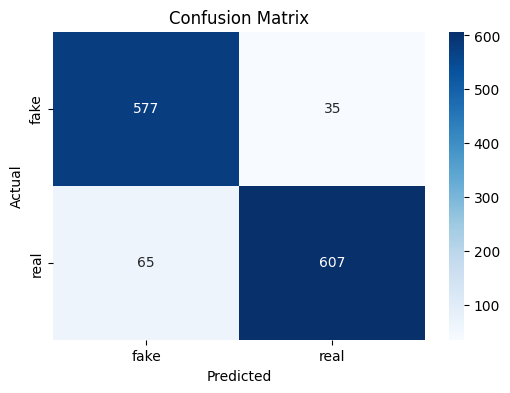

In [46]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔍 Переводим модель в режим оценки
model.eval()

# 📊 Получение предсказаний
all_preds = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        logits = model(x_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# 🎯 Метки истинные
y_true = y_test.tolist()

# 📈 Метрики
acc = accuracy_score(y_true, all_preds)
f1 = f1_score(y_true, all_preds)
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}\n")
print("📋 Classification Report:\n", classification_report(y_true, all_preds, target_names=["fake", "real"]))

# 📊 Матрица ошибок
cm = confusion_matrix(y_true, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["fake", "real"], yticklabels=["fake", "real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


| Модель                      | Accuracy   | F1-score   |
| --------------------------- | ---------- | ---------- |
| TF-IDF (1–2-граммы)         | 0.9097     | 0.9132     |
| TF-IDF + TruncatedSVD (LSA) | 0.8723     | 0.8761     |
| TF-IDF (char n-grams)       | 0.9011     | 0.9043     |
| ⚡ Нейросеть (PyTorch)       | **0.9221** | **0.9239** |


#Финальные выводы:

Базовая TF-IDF-модель с униграммами и биграммами уже даёт высокую точность (F1 > 0.91) и служит хорошей отправной точкой.

TF-IDF + SVD (LSA) снижает размерность, но это сказывается на качестве — метрики заметно ниже. Подходит, если критично ограничение по памяти.

Символьные n-граммы (char n-grams) также работают неплохо и могут быть полезны, если в текстах есть опечатки, особенности написания или сленг.

Нейросеть на PyTorch показала наилучший результат (F1 ≈ 0.92), особенно после обучения на 20 эпохах. Это превзошло целевой порог >0.52 с большим запасом.